In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math

In [ ]:
# Helper functions
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(12, 6))
    plt.plot(test, color='red', label='Actual Stock Price')
    plt.plot(predicted, color='blue', label='Predicted Stock Price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [ ]:
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}".format(rmse))
    return rmse
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mean_absolute_scaled_error(y_true, y_pred, naive_forecast):
    naive_error = np.mean(np.abs(np.diff(naive_forecast)))
    scaled_error = np.mean(np.abs(y_true - y_pred)) / naive_error
    return scaled_error

In [ ]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    return result[1]

In [ ]:
def create_features(residuals, window_size=60):
    features = []
    for i in range(window_size, len(residuals)):
        window = residuals[i-window_size:i]
        features.append({
            'mean': np.mean(window),
            'std': np.std(window),
            'min': np.min(window),
            'max': np.max(window),
            'residual': residuals[i]
        })
    return pd.DataFrame(features)

In [ ]:
dataset = pd.read_csv('IBM_data.csv',
                     skiprows=[1, 2],
                     parse_dates=['Price'],
                     index_col='Price')
dataset.index.name = 'Date'


In [ ]:
# Split data into training and test sets
training_set = dataset[:'2023'].iloc[:,0:1].values
test_set = dataset['2024':].iloc[:,0:1].values

In [ ]:
# Get test dates from the DataFrame index
test_dates = dataset.loc['2024':].index

In [ ]:
# Check stationarity and apply differencing if needed
print("\nStationarity Test on Original Data:")
p_value = check_stationarity(training_set)


Stationarity Test on Original Data:
ADF Statistic: -1.7276403919621175
p-value: 0.41693051475605836
Critical Values:
	1%: -3.43325450880204
	5%: -2.862823135013053
	10%: -2.567453072861103



Data is not stationary. Applying differencing...

Stationarity Test on Differenced Data:
ADF Statistic: -14.822950499482939
p-value: 1.9510137941399385e-27
Critical Values:
	1%: -3.43325450880204
	5%: -2.862823135013053
	10%: -2.567453072861103


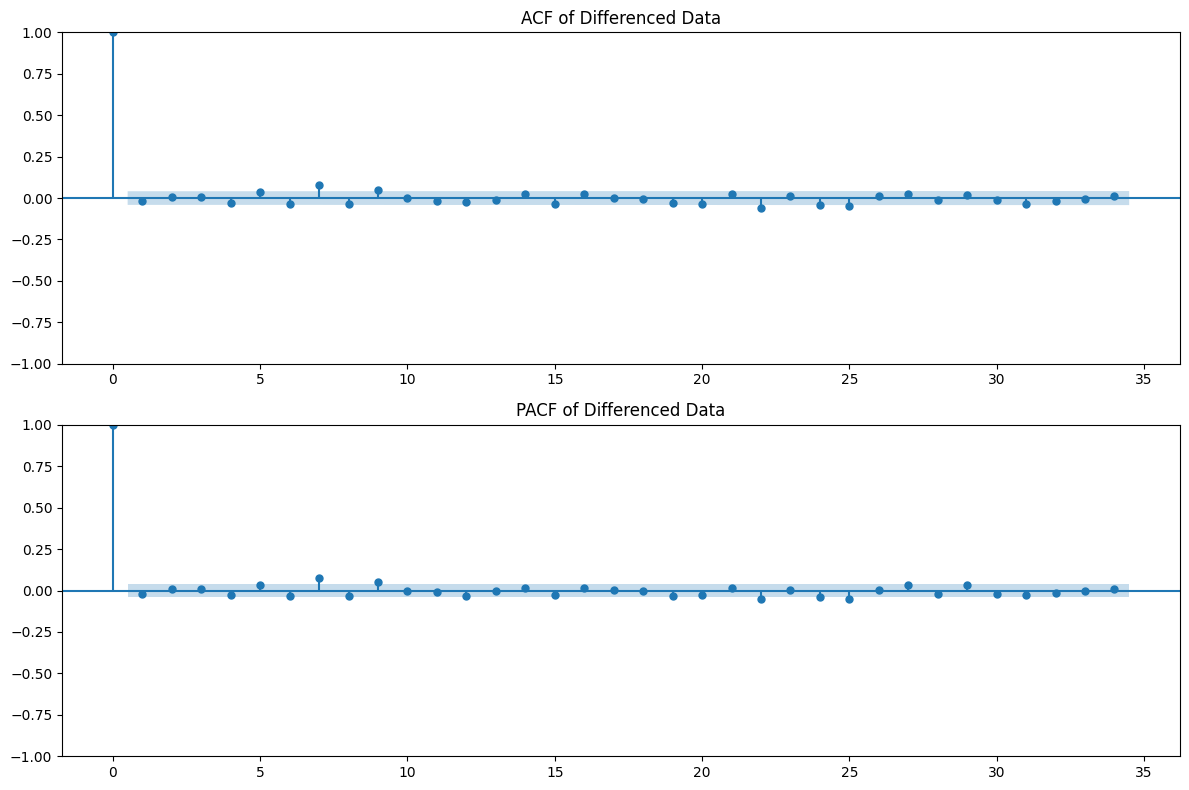

In [ ]:
if p_value > 0.05:
    print("\nData is not stationary. Applying differencing...")
    training_diff = np.diff(training_set, axis=0)
    print("\nStationarity Test on Differenced Data:")
    p_value_diff = check_stationarity(training_diff)

    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plot_acf(training_diff, ax=plt.gca(), title='ACF of Differenced Data')
    plt.subplot(212)
    plot_pacf(training_diff, ax=plt.gca(), title='PACF of Differenced Data')
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plot_acf(training_set, ax=plt.gca(), title='ACF of Original Data')
    plt.subplot(212)
    plot_pacf(training_set, ax=plt.gca(), title='PACF of Original Data')
    plt.tight_layout()
    plt.show()

**p,d,f = (0,1,0)** based on the first spikes in both plots and we applied differencing once

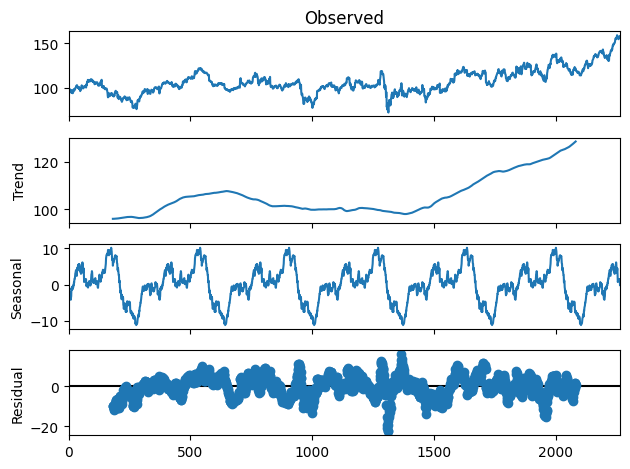

In [ ]:
# Decomposition
decomposition = seasonal_decompose(training_set, model='additive', period=365)
decomposition.plot()
plt.show()

In [ ]:
# Fit ARIMA model using auto_arima
arima_model = auto_arima(training_set, seasonal=False, trace=True)
arima_results = arima_model.fit(training_set)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8363.797, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8364.969, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8364.981, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8362.411, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8366.922, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 8.176 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Get residuals for LSTM
train_residuals = training_set - arima_results.predict_in_sample().reshape(-1,1)
arima_forecast = arima_results.predict(n_periods=len(test_set))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Calculate test residuals
test_residuals = test_set - arima_forecast.reshape(-1,1)

In [ ]:
# Scale residuals
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
train_residuals_scaled = scaler.fit_transform(train_residuals)
test_residuals_scaled = scaler.transform(test_residuals)

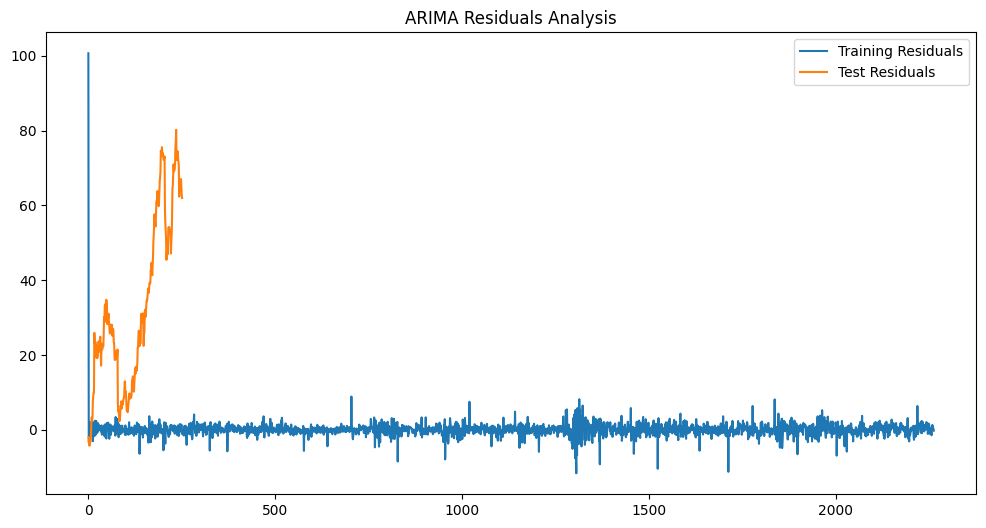

In [ ]:
# Plot residuals
plt.figure(figsize=(12,6))
plt.plot(train_residuals, label='Training Residuals')
plt.plot(test_residuals, label='Test Residuals')
plt.title("ARIMA Residuals Analysis")
plt.legend()
plt.show()

In [ ]:
# Prepare data for LSTM
x_residuals_train, y_residuals_train = [], []
for i in range(60, len(train_residuals_scaled)):
    x_residuals_train.append(train_residuals_scaled[i-60:i, 0])
    y_residuals_train.append(train_residuals_scaled[i, 0])
x_residuals_train, y_residuals_train = np.array(x_residuals_train), np.array(y_residuals_train)
x_residuals_train = np.reshape(x_residuals_train, (x_residuals_train.shape[0], x_residuals_train.shape[1], 1))

In [ ]:
# LSTM model
regressor = Sequential()
regressor.add(LSTM(32, return_sequences=True, input_shape=(60, 1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(16))
regressor.add(Dense(1))

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
regressor.compile(optimizer=optimizer, loss='mae')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = regressor.fit(
    x_residuals_train,
    y_residuals_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.3652 - val_loss: 0.2951
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.2683 - val_loss: 0.1786
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1402 - val_loss: 0.0109
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0271 - val_loss: 0.0139
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0217 - val_loss: 0.0104
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0207 - val_loss: 0.0103
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0224 - val_loss: 0.0103
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0216 - val_loss: 0.0104
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0208 - val_loss: 0.0103
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0207 - val_loss: 0.0103
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0202 - val_loss: 0.0102
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.

In [ ]:
# Prepare test data for LSTM
inputs = np.concatenate((train_residuals_scaled[-60:], test_residuals_scaled))
x_test = []
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# LSTM predictions
lstm_predictions = regressor.predict(x_test)
lstm_residuals = scaler.inverse_transform(lstm_predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [ ]:
# Combine ARIMA and LSTM predictions
final_predictions = arima_forecast + lstm_residuals.flatten()

NameError: name 'arima_forecast' is not defined

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(16, 8))
plt.plot(test_dates, test_set.flatten(), color='red', label='Actual Stock Price')
plt.plot(test_dates, final_predictions, color='blue', label='Predicted Stock Price')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

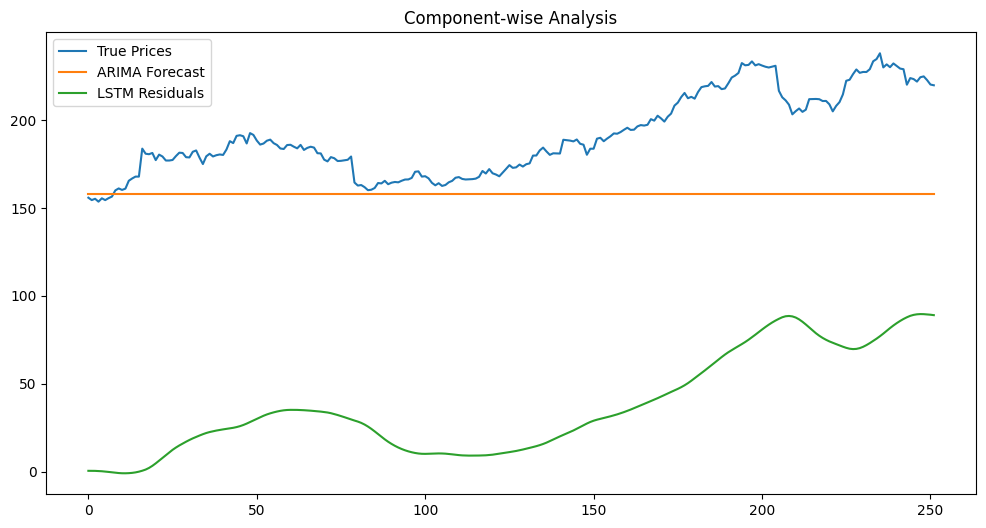

In [ ]:
# Additional analysis
plt.figure(figsize=(12,6))
plt.plot(test_set, label='True Prices')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.plot(2*lstm_residuals, label='LSTM Residuals')
plt.legend()
plt.title("Component-wise Analysis")
plt.show()

In [ ]:
print("Training Residuals Scaled Range:", np.min(train_residuals_scaled), np.max(train_residuals_scaled))
print("Test Residuals Scaled Range:", np.min(test_residuals_scaled), np.max(test_residuals_scaled))

Training Residuals Scaled Range: -0.5 0.5
Test Residuals Scaled Range: -0.4343622852055604 0.3177306289989909


In [ ]:
# True and predicted values
y_true = test_set.flatten()  # Actual test set values
y_pred = final_predictions   # Predicted values from the hybrid model

# Naive forecast (lag-1 persistence model)
naive_forecast = y_true[:-1]  # Use lag-1 values as naive predictions

# Calculate metrics
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mase = mean_absolute_scaled_error(y_true, y_pred, naive_forecast)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MASE: {mase:.2f}")

# Visualize evaluation metrics
metrics = ['MAPE', 'RMSE', 'MASE']
values = [mape, rmse, mase]

MAPE: 4.33%
RMSE: 12.20
MASE: 4.42


In [ ]:
dataset = pd.read_csv('RELIANCE.NS_data.csv',
                     skiprows=[1, 2],
                     parse_dates=['Price'],
                     index_col='Price')
dataset.index.name = 'Date'


In [ ]:
# Split data into training and test sets
training_set = dataset[:'2023'].iloc[:,0:1].values
test_set = dataset['2024':].iloc[:,0:1].values

In [ ]:
# Get test dates from the DataFrame index
test_dates = dataset.loc['2024':].index

In [ ]:
# Check stationarity and apply differencing if needed
print("\nStationarity Test on Original Data:")
p_value = check_stationarity(training_set)


Stationarity Test on Original Data:
ADF Statistic: -0.3775366932806819
p-value: 0.9137823260804366
Critical Values:
	1%: -3.4333057085868255
	5%: -2.8628457425162424
	10%: -2.567465109783999



Data is not stationary. Applying differencing...

Stationarity Test on Differenced Data:
ADF Statistic: -21.274730988159583
p-value: 0.0
Critical Values:
	1%: -3.4333057085868255
	5%: -2.8628457425162424
	10%: -2.567465109783999


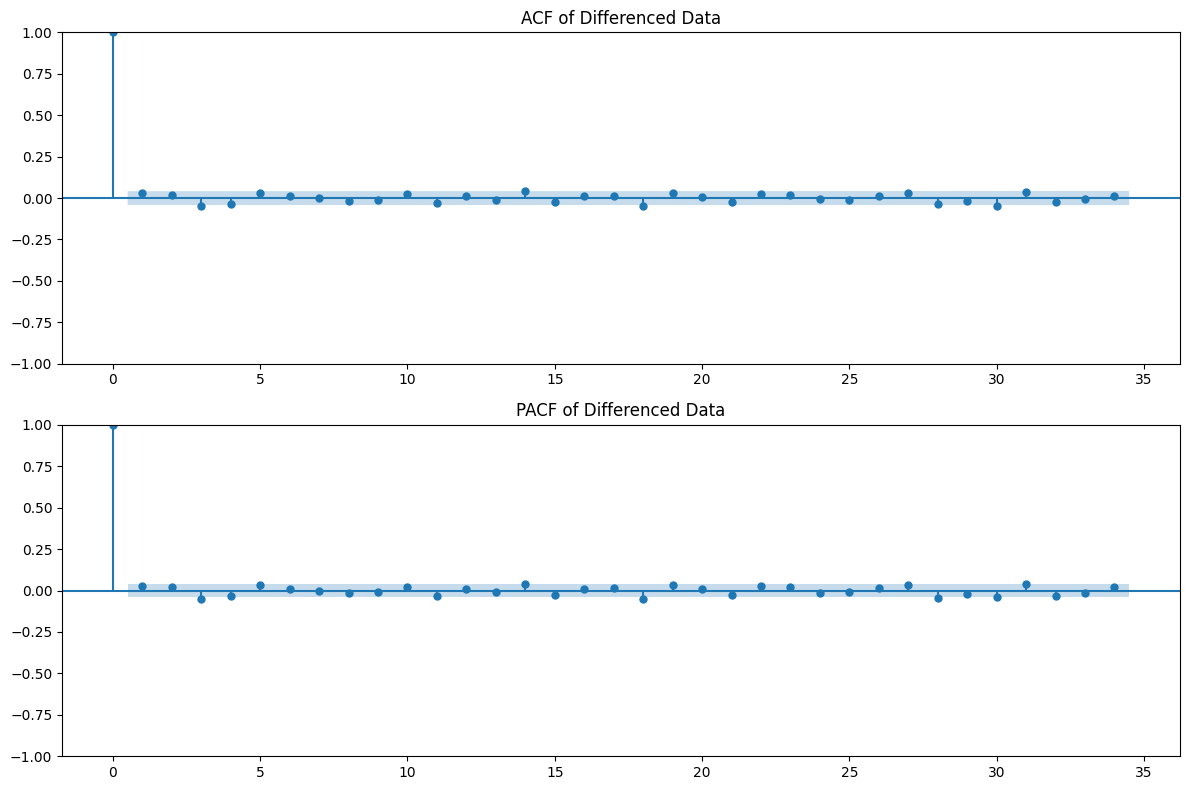

In [ ]:
if p_value > 0.05:
    print("\nData is not stationary. Applying differencing...")
    training_diff = np.diff(training_set, axis=0)
    print("\nStationarity Test on Differenced Data:")
    p_value_diff = check_stationarity(training_diff)

    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plot_acf(training_diff, ax=plt.gca(), title='ACF of Differenced Data')
    plt.subplot(212)
    plot_pacf(training_diff, ax=plt.gca(), title='PACF of Differenced Data')
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plot_acf(training_set, ax=plt.gca(), title='ACF of Original Data')
    plt.subplot(212)
    plot_pacf(training_set, ax=plt.gca(), title='PACF of Original Data')
    plt.tight_layout()
    plt.show()

**p,d,f = (0,1,0)** based on the first spikes in both plots and we applied differencing once

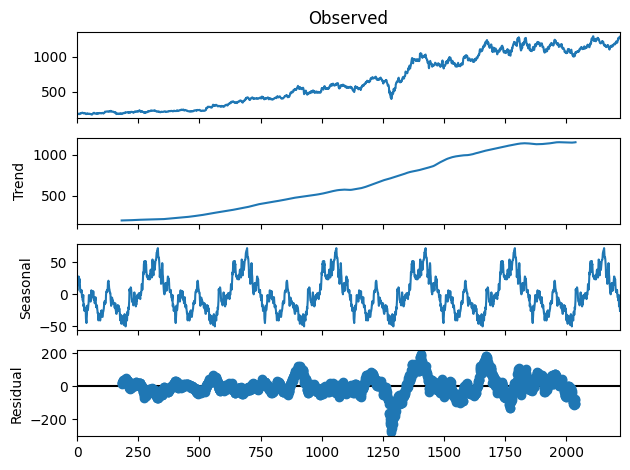

In [ ]:
# Decomposition
decomposition = seasonal_decompose(training_set, model='additive', period=365)
decomposition.plot()
plt.show()

In [ ]:
# Fit ARIMA model using auto_arima
arima_model = auto_arima(training_set, seasonal=False, trace=True)
arima_results = arima_model.fit(training_set)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17426.728, Time=5.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17440.316, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17440.514, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17440.585, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17441.915, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17442.263, Time=3.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17442.677, Time=2.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17436.325, Time=3.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=17436.276, Time=5.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17442.348, Time=4.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=17438.809, Time=3.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17439.010, Time=1.71 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=17435.278, Time=10.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=17428.210, Time=1.92 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 42.627 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Get residuals for LSTM
train_residuals = training_set - arima_results.predict_in_sample().reshape(-1,1)
arima_forecast = arima_results.predict(n_periods=len(test_set))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Calculate test residuals
test_residuals = test_set - arima_forecast.reshape(-1,1)

In [ ]:
# Scale residuals
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
train_residuals_scaled = scaler.fit_transform(train_residuals)
test_residuals_scaled = scaler.transform(test_residuals)

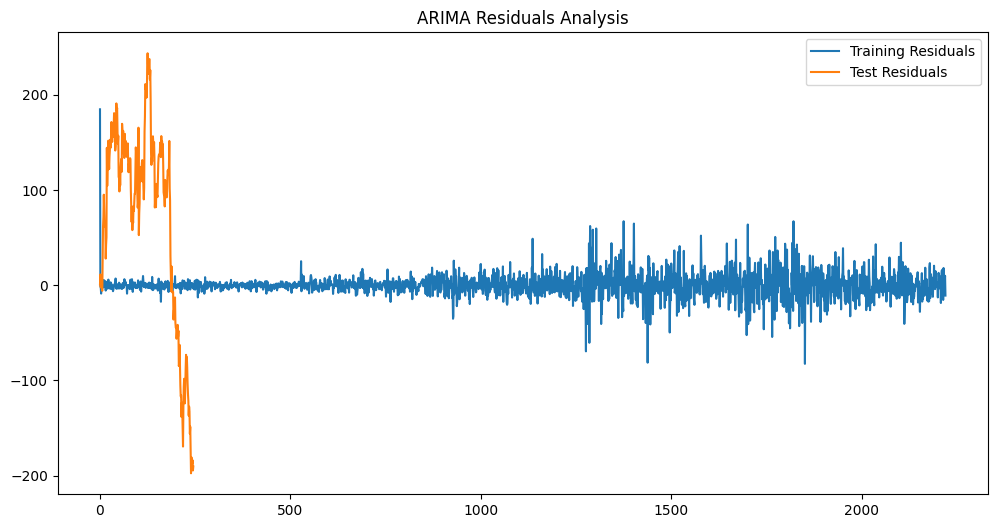

In [ ]:
# Plot residuals
plt.figure(figsize=(12,6))
plt.plot(train_residuals, label='Training Residuals')
plt.plot(test_residuals, label='Test Residuals')
plt.title("ARIMA Residuals Analysis")
plt.legend()
plt.show()

In [ ]:
# Prepare data for LSTM
x_residuals_train, y_residuals_train = [], []
for i in range(60, len(train_residuals_scaled)):
    x_residuals_train.append(train_residuals_scaled[i-60:i, 0])
    y_residuals_train.append(train_residuals_scaled[i, 0])
x_residuals_train, y_residuals_train = np.array(x_residuals_train), np.array(y_residuals_train)
x_residuals_train = np.reshape(x_residuals_train, (x_residuals_train.shape[0], x_residuals_train.shape[1], 1))

In [ ]:
# LSTM model
regressor = Sequential()
regressor.add(LSTM(32, return_sequences=True, input_shape=(60, 1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(16))
regressor.add(Dense(1))

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
regressor.compile(optimizer=optimizer, loss='mae')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = regressor.fit(
    x_residuals_train,
    y_residuals_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 0.2047 - val_loss: 0.1683
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1544 - val_loss: 0.1140
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0958 - val_loss: 0.0542
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0356 - val_loss: 0.0437
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0301 - val_loss: 0.0432
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0295 - val_loss: 0.0433
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0295 - val_loss: 0.0432
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0300 - val_loss: 0.0433
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0290 - val_loss: 0.0432
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0273 - val_loss: 0.0433
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0281 - val_loss: 0.0432
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0

In [ ]:
# Prepare test data for LSTM
inputs = np.concatenate((train_residuals_scaled[-60:], test_residuals_scaled))
x_test = []
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# LSTM predictions
lstm_predictions = regressor.predict(x_test)
lstm_residuals = scaler.inverse_transform(lstm_predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [ ]:
# Combine ARIMA and LSTM predictions
final_predictions = arima_forecast + 3.5*lstm_residuals.flatten()

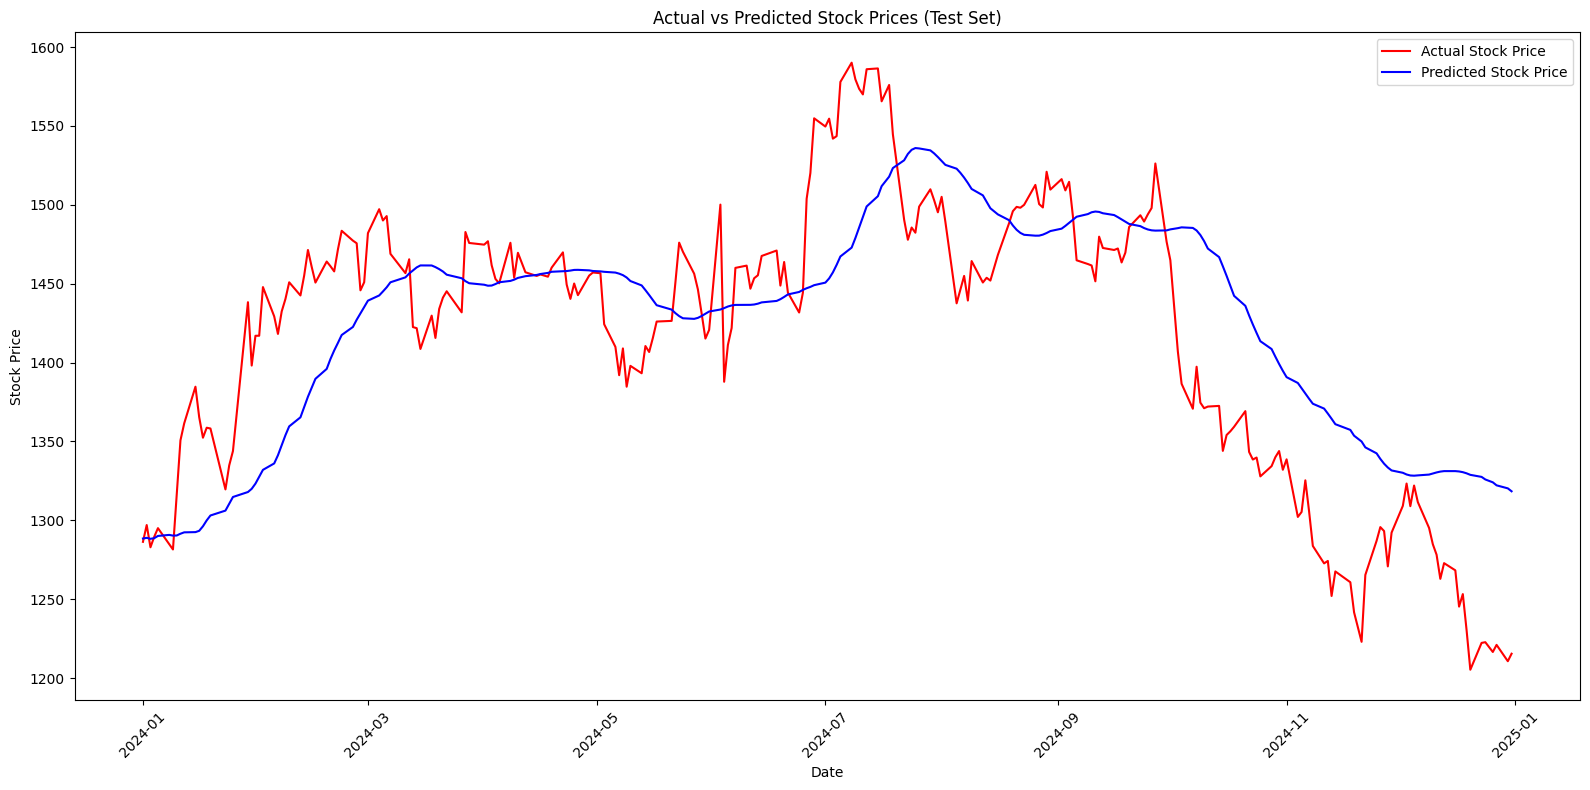

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(16, 8))
plt.plot(test_dates, test_set.flatten(), color='red', label='Actual Stock Price')
plt.plot(test_dates, final_predictions, color='blue', label='Predicted Stock Price')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

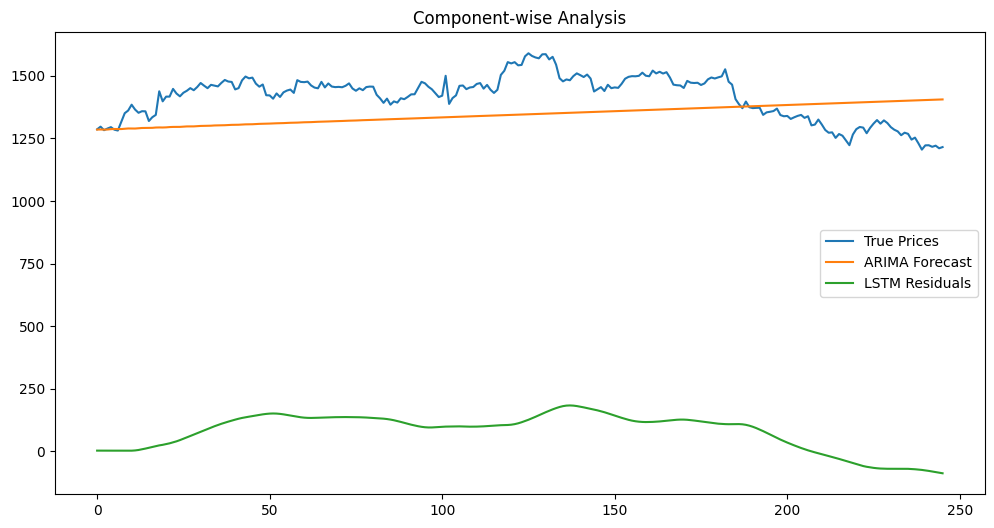

In [ ]:
# Additional analysis
plt.figure(figsize=(12,6))
plt.plot(test_set, label='True Prices')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.plot(3.5*lstm_residuals, label='LSTM Residuals')
plt.legend()
plt.title("Component-wise Analysis")
plt.show()

In [ ]:
print("Training Residuals Scaled Range:", np.min(train_residuals_scaled), np.max(train_residuals_scaled))
print("Test Residuals Scaled Range:", np.min(test_residuals_scaled), np.max(test_residuals_scaled))

Training Residuals Scaled Range: -0.5 0.49999999999999994
Test Residuals Scaled Range: -0.9299323014982019 0.7201597339455805


In [ ]:
# True and predicted values
y_true = test_set.flatten()  # Actual test set values
y_pred = final_predictions   # Predicted values from the hybrid model

# Naive forecast (lag-1 persistence model)
naive_forecast = y_true[:-1]  # Use lag-1 values as naive predictions

# Calculate metrics
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mase = mean_absolute_scaled_error(y_true, y_pred, naive_forecast)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MASE: {mase:.2f}")

# Visualize evaluation metrics
metrics = ['MAPE', 'RMSE', 'MASE']
values = [mape, rmse, mase]



MAPE: 3.44%
RMSE: 58.86
MASE: 3.28


In [ ]:
dataset = pd.read_csv('TCS.NS_data.csv',
                     skiprows=[1, 2],
                     parse_dates=['Price'],
                     index_col='Price')
dataset.index.name = 'Date'


In [ ]:
# Split data into training and test sets
training_set = dataset[:'2023'].iloc[:,0:1].values
test_set = dataset['2024':].iloc[:,0:1].values

In [ ]:
# Get test dates from the DataFrame index
test_dates = dataset.loc['2024':].index

In [ ]:
# Check stationarity and apply differencing if needed
print("\nStationarity Test on Original Data:")
p_value = check_stationarity(training_set)


Stationarity Test on Original Data:
ADF Statistic: 0.03252111454344372
p-value: 0.9611403385844097
Critical Values:
	1%: -3.43333403252856
	5%: -2.862858248918234
	10%: -2.5674717686007003



Data is not stationary. Applying differencing...

Stationarity Test on Differenced Data:
ADF Statistic: -10.16107950824824
p-value: 7.505194872395045e-18
Critical Values:
	1%: -3.43333403252856
	5%: -2.862858248918234
	10%: -2.5674717686007003


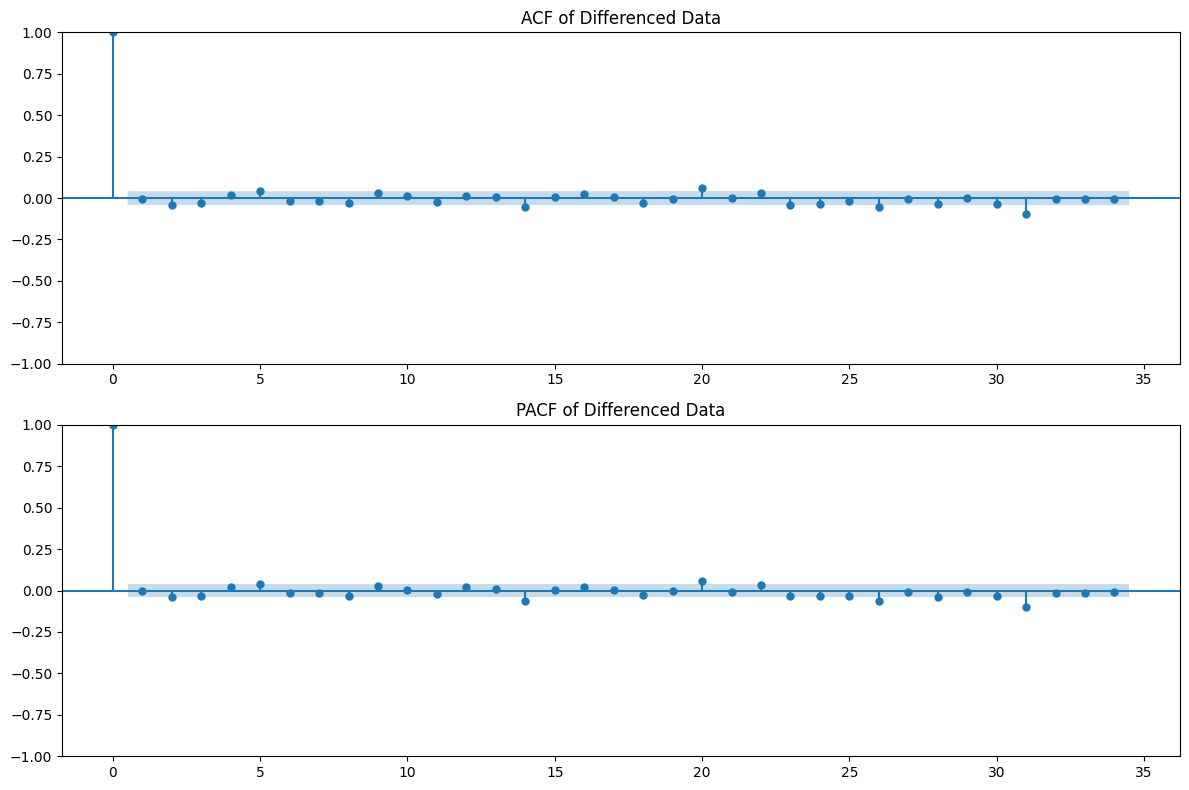

In [ ]:
if p_value > 0.05:
    print("\nData is not stationary. Applying differencing...")
    training_diff = np.diff(training_set, axis=0)
    print("\nStationarity Test on Differenced Data:")
    p_value_diff = check_stationarity(training_diff)

    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plot_acf(training_diff, ax=plt.gca(), title='ACF of Differenced Data')
    plt.subplot(212)
    plot_pacf(training_diff, ax=plt.gca(), title='PACF of Differenced Data')
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plot_acf(training_set, ax=plt.gca(), title='ACF of Original Data')
    plt.subplot(212)
    plot_pacf(training_set, ax=plt.gca(), title='PACF of Original Data')
    plt.tight_layout()
    plt.show()

**p,d,f = (0,1,0)** based on the first spikes in both plots and we applied differencing once

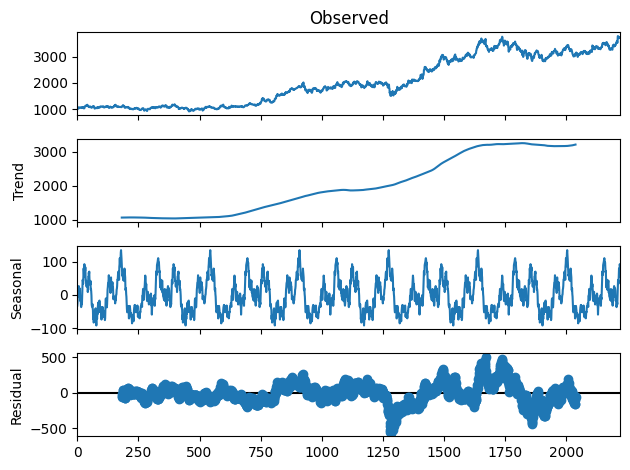

In [ ]:
# Decomposition
decomposition = seasonal_decompose(training_set, model='additive', period=365)
decomposition.plot()
plt.show()

In [ ]:
# Fit ARIMA model using auto_arima
arima_model = auto_arima(training_set, seasonal=False, trace=True)
arima_results = arima_model.fit(training_set)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21675.579, Time=1.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21676.942, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21678.925, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21678.926, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21678.066, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21678.559, Time=2.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21678.247, Time=3.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=21677.368, Time=3.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=21665.435, Time=5.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21679.408, Time=2.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21676.136, Time=7.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=21666.761, Time=9.92 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=21679.675, Time=3.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=21677.826, Time=8.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=21666.621, Time=4.51 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 54.634 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Get residuals for LSTM
train_residuals = training_set - arima_results.predict_in_sample().reshape(-1,1)
arima_forecast = arima_results.predict(n_periods=len(test_set))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Calculate test residuals
test_residuals = test_set - arima_forecast.reshape(-1,1)

In [ ]:
# Scale residuals
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
train_residuals_scaled = scaler.fit_transform(train_residuals)
test_residuals_scaled = scaler.transform(test_residuals)

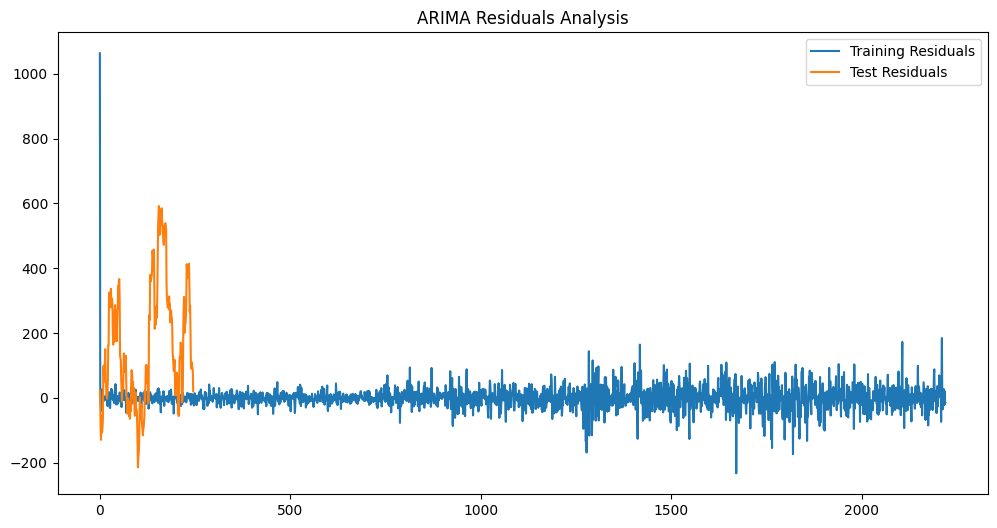

In [ ]:
# Plot residuals
plt.figure(figsize=(12,6))
plt.plot(train_residuals, label='Training Residuals')
plt.plot(test_residuals, label='Test Residuals')
plt.title("ARIMA Residuals Analysis")
plt.legend()
plt.show()

In [ ]:
# Prepare data for LSTM
x_residuals_train, y_residuals_train = [], []
for i in range(60, len(train_residuals_scaled)):
    x_residuals_train.append(train_residuals_scaled[i-60:i, 0])
    y_residuals_train.append(train_residuals_scaled[i, 0])
x_residuals_train, y_residuals_train = np.array(x_residuals_train), np.array(y_residuals_train)
x_residuals_train = np.reshape(x_residuals_train, (x_residuals_train.shape[0], x_residuals_train.shape[1], 1))

In [ ]:
# LSTM model
regressor = Sequential()
regressor.add(LSTM(32, return_sequences=True, input_shape=(60, 1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(16))
regressor.add(Dense(1))

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
regressor.compile(optimizer=optimizer, loss='mae')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = regressor.fit(
    x_residuals_train,
    y_residuals_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.2824 - val_loss: 0.2183
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1935 - val_loss: 0.1157
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0844 - val_loss: 0.0274
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0230 - val_loss: 0.0235
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0206 - val_loss: 0.0231
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0206 - val_loss: 0.0232
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0199 - val_loss: 0.0231
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0209 - val_loss: 0.0232
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0203 - val_loss: 0.0233
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0209 - val_loss: 0.0232
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0194 - val_loss: 0.0231
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

In [ ]:
# Prepare test data for LSTM
inputs = np.concatenate((train_residuals_scaled[-60:], test_residuals_scaled))
x_test = []
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# LSTM predictions
lstm_predictions = regressor.predict(x_test)
lstm_residuals = scaler.inverse_transform(lstm_predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [ ]:
# Combine ARIMA and LSTM predictions
final_predictions = arima_forecast + 4*lstm_residuals.flatten()

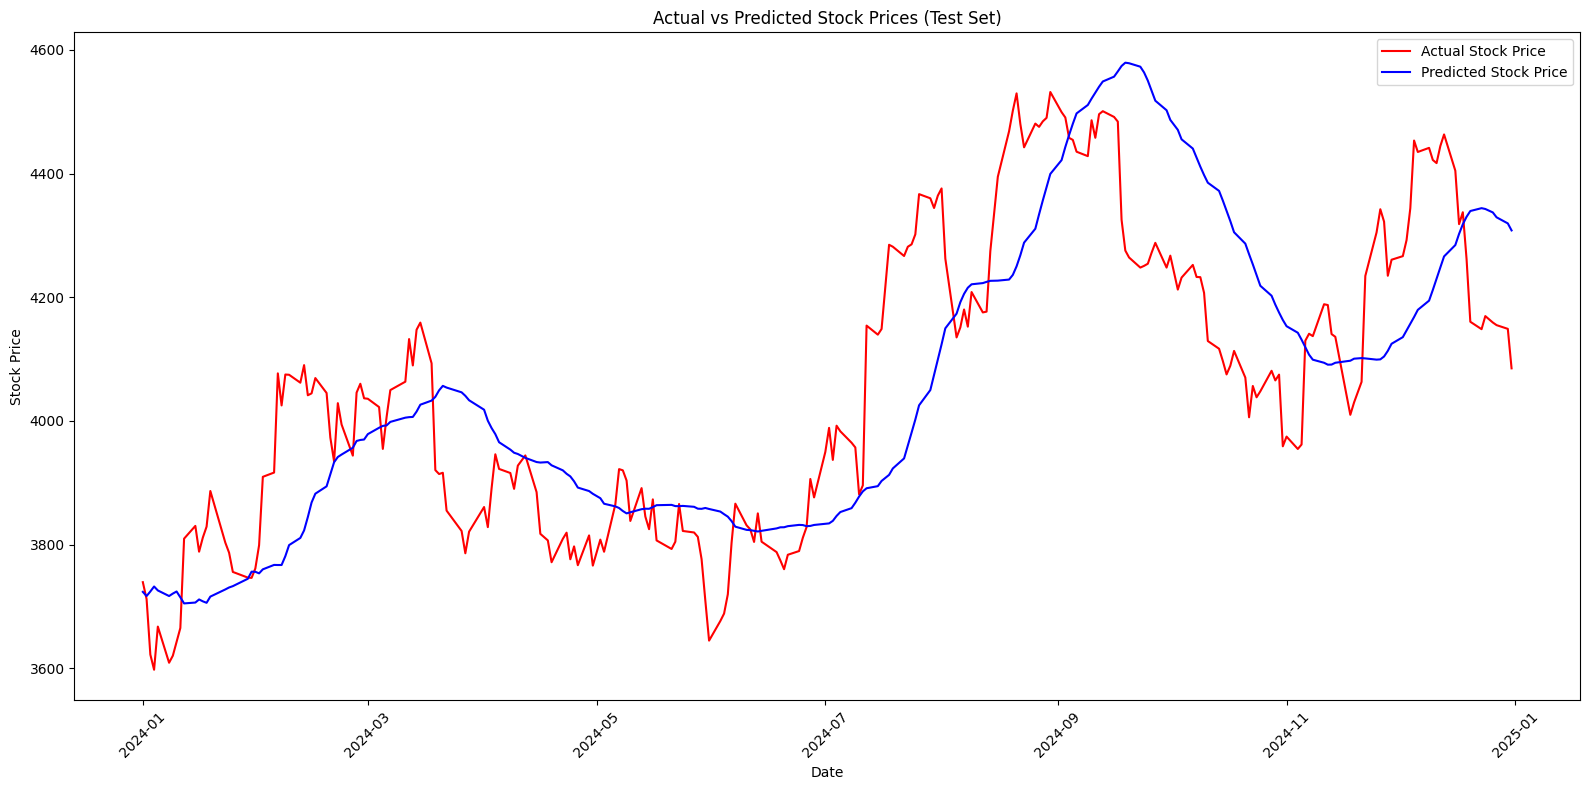

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(16, 8))
plt.plot(test_dates, test_set.flatten(), color='red', label='Actual Stock Price')
plt.plot(test_dates, final_predictions, color='blue', label='Predicted Stock Price')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

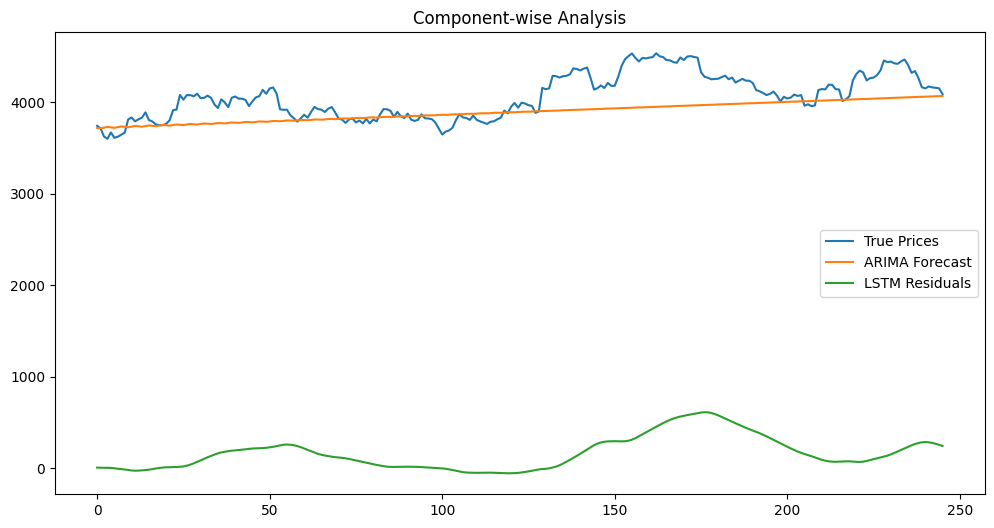

In [ ]:
# Additional analysis
plt.figure(figsize=(12,6))
plt.plot(test_set, label='True Prices')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.plot(4*lstm_residuals, label='LSTM Residuals')
plt.legend()
plt.title("Component-wise Analysis")
plt.show()

In [ ]:
print("Training Residuals Scaled Range:", np.min(train_residuals_scaled), np.max(train_residuals_scaled))
print("Test Residuals Scaled Range:", np.min(test_residuals_scaled), np.max(test_residuals_scaled))

Training Residuals Scaled Range: -0.5 0.5
Test Residuals Scaled Range: -0.48598137794905905 0.1362216180427105


In [ ]:
# True and predicted values
y_true = test_set.flatten()  # Actual test set values
y_pred = final_predictions   # Predicted values from the hybrid model

# Naive forecast (lag-1 persistence model)
naive_forecast = y_true[:-1]  # Use lag-1 values as naive predictions

# Calculate metrics
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mase = mean_absolute_scaled_error(y_true, y_pred, naive_forecast)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MASE: {mase:.2f}")

# Visualize evaluation metrics
metrics = ['MAPE', 'RMSE', 'MASE']
values = [mape, rmse, mase]



MAPE: 3.13%
RMSE: 158.15
MASE: 3.33


In [ ]:
dataset = pd.read_csv('^NSEI_data.csv',
                     skiprows=[1, 2],
                     parse_dates=['Price'],
                     index_col='Price')
dataset.index.name = 'Date'


In [ ]:
# Split data into training and test sets
training_set = dataset[:'2023'].iloc[:,0:1].values
test_set = dataset['2024':].iloc[:,0:1].values

In [ ]:
# Get test dates from the DataFrame index
test_dates = dataset.loc['2024':].index

In [ ]:
# Check stationarity and apply differencing if needed
print("\nStationarity Test on Original Data:")
p_value = check_stationarity(training_set)


Stationarity Test on Original Data:
ADF Statistic: 0.6009071902251862
p-value: 0.9876379685115638
Critical Values:
	1%: -3.4333191288144413
	5%: -2.8628516682161713
	10%: -2.567468264817643



Data is not stationary. Applying differencing...

Stationarity Test on Differenced Data:
ADF Statistic: -16.902674750220086
p-value: 1.024849609035373e-29
Critical Values:
	1%: -3.4333191288144413
	5%: -2.8628516682161713
	10%: -2.567468264817643


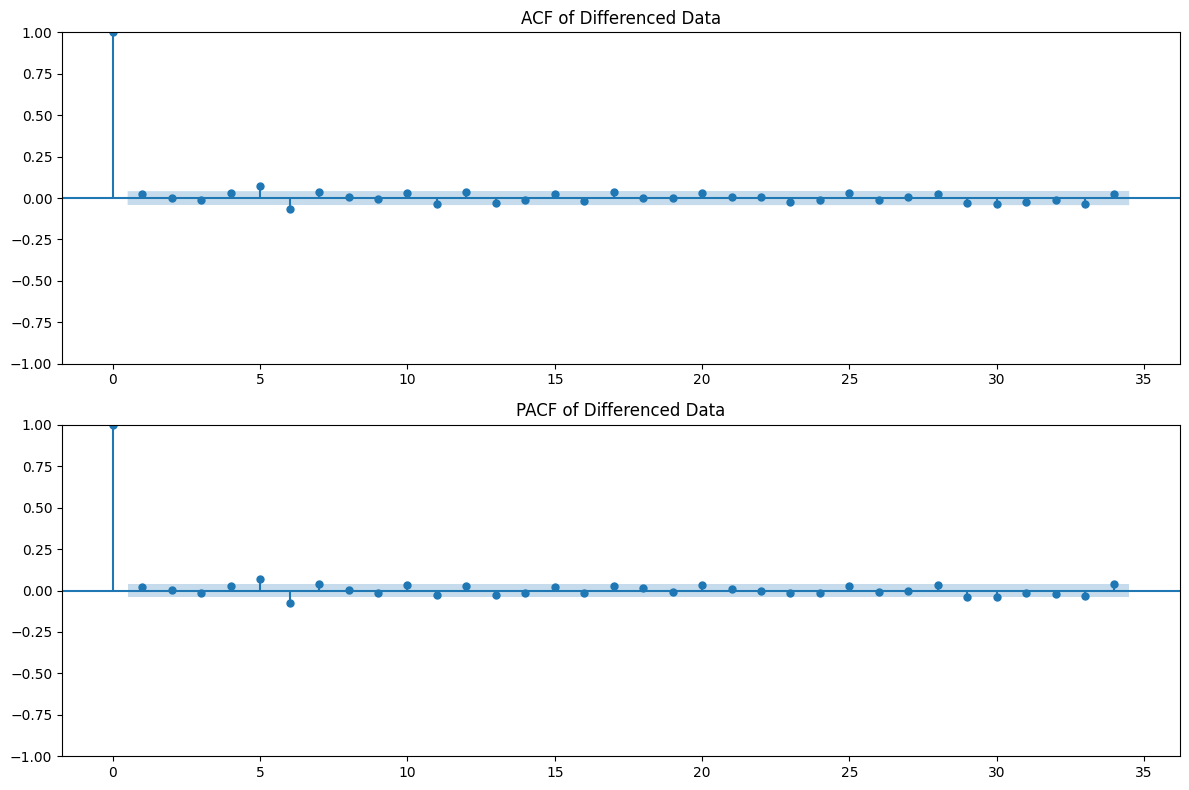

In [ ]:
if p_value > 0.05:
    print("\nData is not stationary. Applying differencing...")
    training_diff = np.diff(training_set, axis=0)
    print("\nStationarity Test on Differenced Data:")
    p_value_diff = check_stationarity(training_diff)

    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plot_acf(training_diff, ax=plt.gca(), title='ACF of Differenced Data')
    plt.subplot(212)
    plot_pacf(training_diff, ax=plt.gca(), title='PACF of Differenced Data')
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plot_acf(training_set, ax=plt.gca(), title='ACF of Original Data')
    plt.subplot(212)
    plot_pacf(training_set, ax=plt.gca(), title='PACF of Original Data')
    plt.tight_layout()
    plt.show()

**p,d,f = (0,1,0)** based on the first spikes in both plots and we applied differencing once

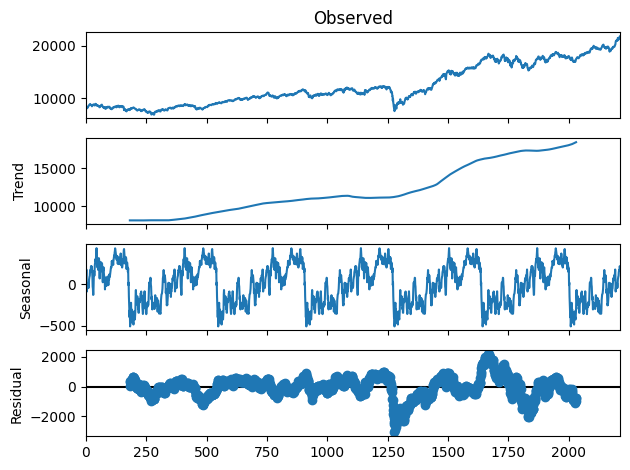

In [ ]:
# Decomposition
decomposition = seasonal_decompose(training_set, model='additive', period=365)
decomposition.plot()
plt.show()

In [ ]:
# Fit ARIMA model using auto_arima
arima_model = auto_arima(training_set, seasonal=False, trace=True)
arima_results = arima_model.fit(training_set)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27657.329, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27658.126, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27658.131, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27660.434, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27660.129, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 7.770 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Get residuals for LSTM
train_residuals = training_set - arima_results.predict_in_sample().reshape(-1,1)
arima_forecast = arima_results.predict(n_periods=len(test_set))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Calculate test residuals
test_residuals = test_set - arima_forecast.reshape(-1,1)

In [ ]:
# Scale residuals
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
train_residuals_scaled = scaler.fit_transform(train_residuals)
test_residuals_scaled = scaler.transform(test_residuals)

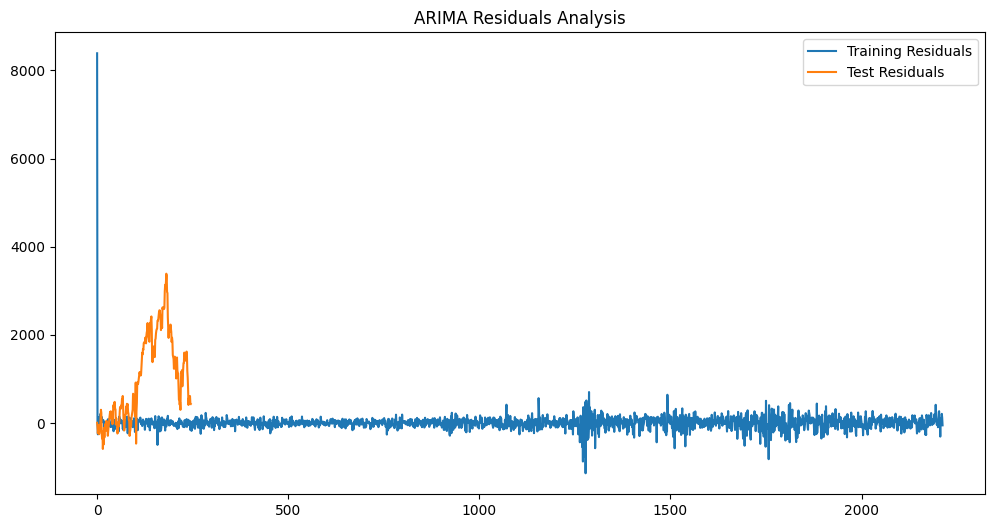

In [ ]:
# Plot residuals
plt.figure(figsize=(12,6))
plt.plot(train_residuals, label='Training Residuals')
plt.plot(test_residuals, label='Test Residuals')
plt.title("ARIMA Residuals Analysis")
plt.legend()
plt.show()

In [ ]:
# Prepare data for LSTM
x_residuals_train, y_residuals_train = [], []
for i in range(60, len(train_residuals_scaled)):
    x_residuals_train.append(train_residuals_scaled[i-60:i, 0])
    y_residuals_train.append(train_residuals_scaled[i, 0])
x_residuals_train, y_residuals_train = np.array(x_residuals_train), np.array(y_residuals_train)
x_residuals_train = np.reshape(x_residuals_train, (x_residuals_train.shape[0], x_residuals_train.shape[1], 1))

In [ ]:
# LSTM model
regressor = Sequential()
regressor.add(LSTM(32, return_sequences=True, input_shape=(60, 1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(16))
regressor.add(Dense(1))

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
regressor.compile(optimizer=optimizer, loss='mae')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = regressor.fit(
    x_residuals_train,
    y_residuals_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.3790 - val_loss: 0.2834
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.2501 - val_loss: 0.1384
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0990 - val_loss: 0.0286
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0320 - val_loss: 0.0118
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0285 - val_loss: 0.0114
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0277 - val_loss: 0.0114
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0261 - val_loss: 0.0115
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0265 - val_loss: 0.0114
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0259 - val_loss: 0.0115
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0245 - val_loss: 0.0114
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0239 - val_loss: 0.0114
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.

In [ ]:
# Prepare test data for LSTM
inputs = np.concatenate((train_residuals_scaled[-60:], test_residuals_scaled))
x_test = []
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# LSTM predictions
lstm_predictions = regressor.predict(x_test)
lstm_residuals = scaler.inverse_transform(lstm_predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [ ]:
# Combine ARIMA and LSTM predictions
final_predictions = arima_forecast + 2.4*lstm_residuals.flatten()

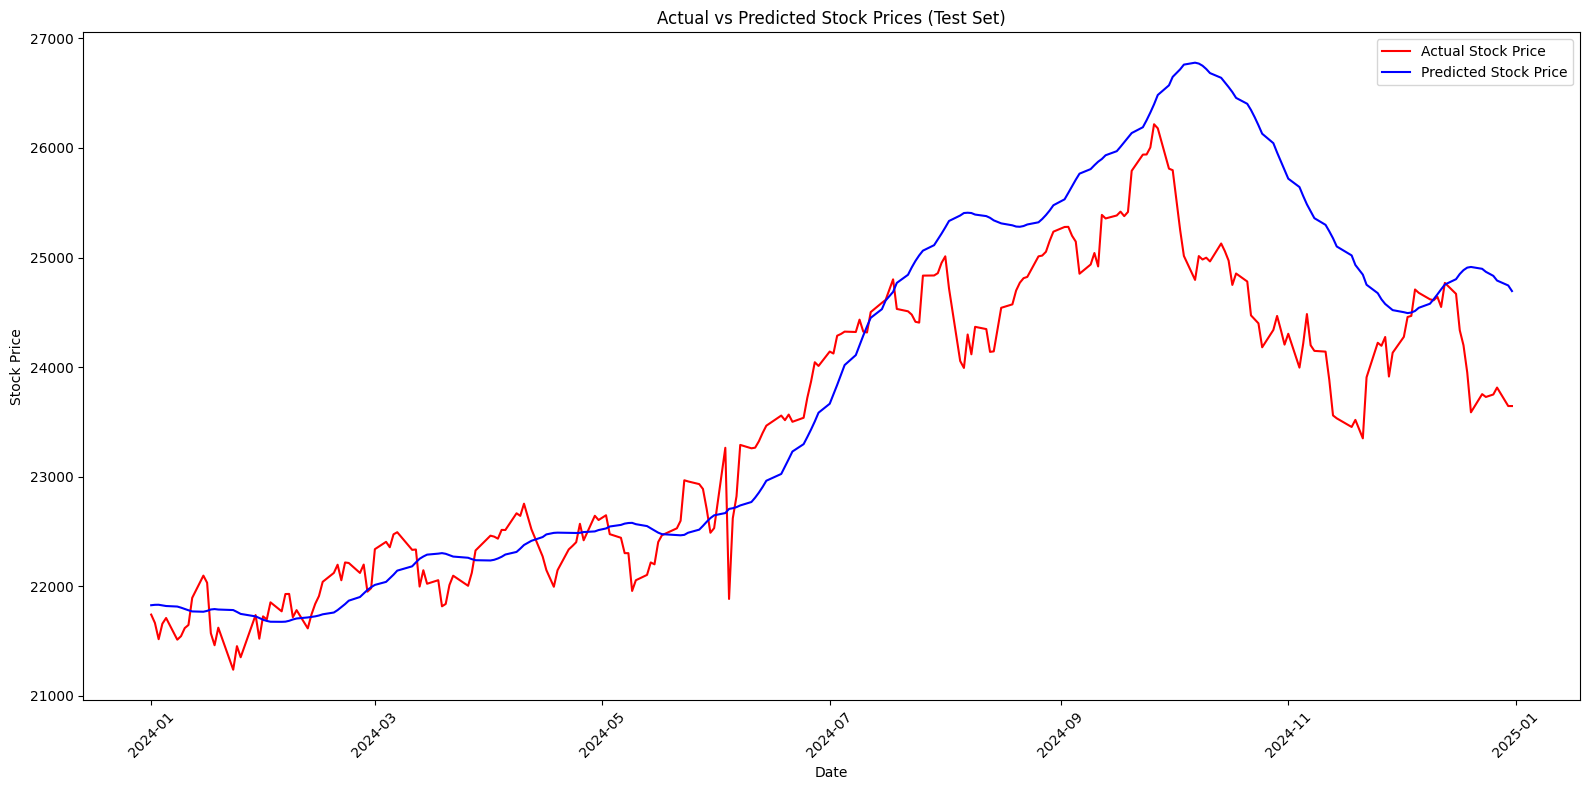

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(16, 8))
plt.plot(test_dates, test_set.flatten(), color='red', label='Actual Stock Price')
plt.plot(test_dates, final_predictions, color='blue', label='Predicted Stock Price')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

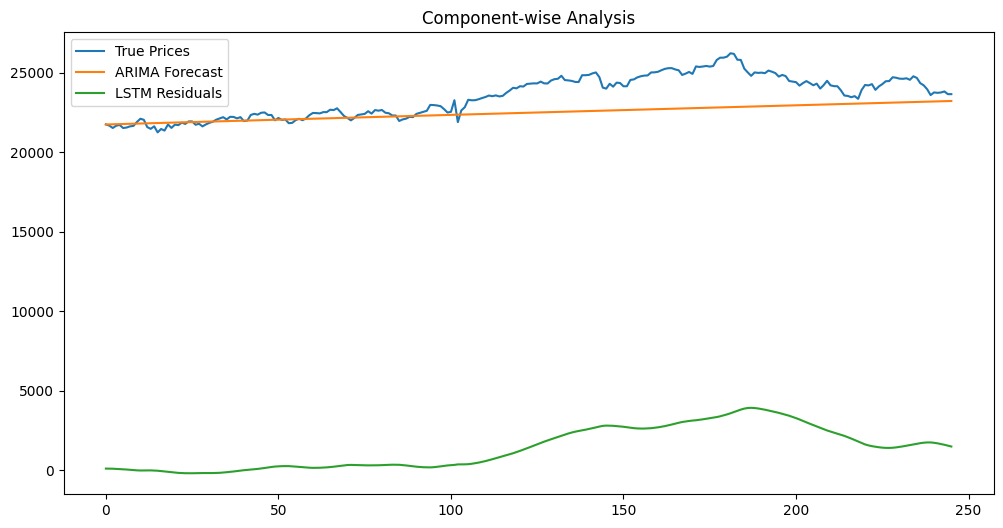

In [ ]:
# Additional analysis
plt.figure(figsize=(12,6))
plt.plot(test_set, label='True Prices')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.plot(2.4*lstm_residuals, label='LSTM Residuals')
plt.legend()
plt.title("Component-wise Analysis")
plt.show()

In [ ]:
print("Training Residuals Scaled Range:", np.min(train_residuals_scaled), np.max(train_residuals_scaled))
print("Test Residuals Scaled Range:", np.min(test_residuals_scaled), np.max(test_residuals_scaled))

Training Residuals Scaled Range: -0.5 0.5
Test Residuals Scaled Range: -0.4420640874800648 -0.02483643970010002


In [ ]:
# Evaluation Metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_scaled_error(y_true, y_pred, naive_forecast):
    naive_error = np.mean(np.abs(np.diff(naive_forecast)))
    scaled_error = np.mean(np.abs(y_true - y_pred)) / naive_error
    return scaled_error

# True and predicted values
y_true = test_set.flatten()  # Actual test set values
y_pred = final_predictions   # Predicted values from the hybrid model

# Naive forecast (lag-1 persistence model)
naive_forecast = y_true[:-1]  # Use lag-1 values as naive predictions

# Calculate metrics
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mase = mean_absolute_scaled_error(y_true, y_pred, naive_forecast)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MASE: {mase:.2f}")

# Visualize evaluation metrics
metrics = ['MAPE', 'RMSE', 'MASE']
values = [mape, rmse, mase]




MAPE: 2.25%
RMSE: 739.54
MASE: 3.80


**After seeing these trends, There's no much increase in NIFTY index trend and its falling at the year end, so best sell the reliance and infosys stocks and buy the IBM stocks**